# Calculating Transit Timing Variations (TTV) with REBOUND
The following code finds the transit times in a two planet system. The transit times of the inner planet are not exactly periodic, due to planet-planet interactions.

First, let's import the REBOUND and numpy packages.

In [1]:
import rebound
import numpy as np

Let's set up a coplanar two planet system.

In [2]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5, a=1,e=0.1,omega=0.25)
sim.add(m=1e-5, a=1.757)
sim.move_to_com()

We're now going to integrate the system forward in time. We assume the observer of the system is in the direction of the positive x-axis. We want to meassure the time when the inner planet transits. In this geometry, this happens when the y coordinate of the planet changes sign. Whenever we detect a change in sign between two steps, we try to find the transit time, which must lie somewhere within the last step, by bisection. 

In [3]:
N=174
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[1].y
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*p[1].y<0. and p[1].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*p[1].y<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit 

Next, we do a linear least square fit to remove the linear trend from the transit times, thus leaving us with the transit time variations.

In [4]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

Finally, let us plot the TTVs.

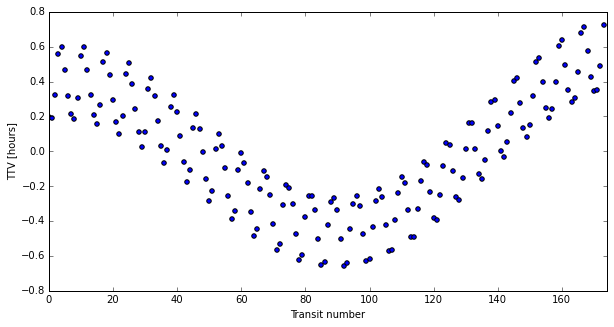

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));